In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
from IPython.display import display, HTML
import os
import numpy as np
import pandas as pd
import copy

In [2]:
def ucitaj_povrsinske_proteine(putanja_do_fajla):
    povrsinski_proteini = {}
    povrsinski_proteini_nazivi = []
    with open(putanja_do_fajla, "r") as fajl:
        for red in SeqIO.parse(fajl, "fasta"):
            if any(kljucna_rec in red.description for kljucna_rec in ['spike', 'surface']):
                povrsinski_proteini[red.description] = red.seq
                povrsinski_proteini_nazivi.append(red.description.split(" | ")[1])
                
    return povrsinski_proteini, povrsinski_proteini_nazivi

In [3]:
putanja_do_fajla = "podaci/proteini/rnk.fasta"
povrsinski_proteini, povrsinski_proteini_nazivi = ucitaj_povrsinske_proteine(putanja_do_fajla)

In [4]:
def rnk_u_kodone(rnk):
    kodoni = [rnk[i:i+3] for i in range(0, len(rnk), 3)]
    return kodoni

S obzirom da duzine rnk koje kodiraju povrsinske proteine nisu jednake duzine, moramo da im izjednacimo duzine kako bismo koristili p-adicno ili Hamingovo rastojanje.

In [5]:
# 1. pristup: kracu sekvencu dopunimo do duzine duze sekvence najucestalijim kodonom
def izjednacavanje_sekvenci_kodonima(sekv1, sekv2):
    sekv1, sekv2 = rnk_u_kodone(sekv1), rnk_u_kodone(sekv2)
    
    duza_sekvenca = sekv1 if len(sekv1) > len(sekv2) else sekv2
    kraca_sekvenca = sekv1 if len(duza_sekvenca) == len(sekv2) else sekv2
    ucestalost_kodona = {}
    
    for kodon in kraca_sekvenca:
        if kodon in ucestalost_kodona:
            ucestalost_kodona[kodon] += 1
        else:
            ucestalost_kodona[kodon] = 1
        
    najcesci_kodon = max(ucestalost_kodona, key=ucestalost_kodona.get)
    broj_pojavljivanja = ucestalost_kodona[najcesci_kodon]

    broj_kodona_dodati = len(duza_sekvenca) - len(kraca_sekvenca)
    dopunjeni_kodoni = [najcesci_kodon] * broj_kodona_dodati

    # da se ne bi iz nekog razloga direktno menjale vrednosti, pravimo kopiju 
    dopunjena_sekvenca = kraca_sekvenca.copy()
    dopunjena_sekvenca.extend(dopunjeni_kodoni)

    dopunjena_sekvenca = ''.join(str(seq) for seq in dopunjena_sekvenca)
    duza_sekvenca = ''.join(str(seq) for seq in duza_sekvenca)
    
    return dopunjena_sekvenca, duza_sekvenca


# 2. pristup: kracu sekvencu dopunimo do duzine duze sekvence najucestalijim nukleotidom
def izjednacavanje_sekvenci_nukleotidima(sek1, sek2):
    duza_sekvenca = sek1 if len(sek1) > len(sek2) else sek2
    kraca_sekvenca = sek1 if len(duza_sekvenca) == len(sek2) else sek2
    ucestalost_nukleotida = {}
    
    for nukleotid in kraca_sekvenca:
        if nukleotid in ucestalost_nukleotida:
            ucestalost_nukleotida[nukleotid] += 1
        else:
            ucestalost_nukleotida[nukleotid] = 1
        
    najcesci_nukleotid = max(ucestalost_nukleotida, key=ucestalost_nukleotida.get)

    broj_nukleotida_dodati = len(duza_sekvenca) - len(kraca_sekvenca)
    dopunjeni_nukleotidi = [najcesci_nukleotid] * broj_nukleotida_dodati
    
    dopunjena_sekvenca = kraca_sekvenca + ''.join(dopunjeni_nukleotidi)
        
    return dopunjena_sekvenca, duza_sekvenca

## P-adično rastojanje

In [6]:
# Prevodjenje kodona u p-adicne brojeve
def kodon_u_p_adicni_broj(kodon):
    kodon_u_broj = {
        'CCC': 111, 'CCU': 113, 'CCA': 112, 'CCG': 114,
        'CAC': 121, 'CAU': 123, 'CAA': 122, 'CAG': 124,
        'CUC': 131, 'CUU': 133, 'CUA': 132, 'CUG': 134,
        'CGC': 141, 'CGU': 143, 'CGA': 142, 'CGG': 144,
        'ACC': 211, 'ACU': 213, 'ACA': 212, 'ACG': 214,
        'AAC': 221, 'AAU': 223, 'AAA': 222, 'AAG': 224,
        'AUC': 231, 'AUU': 233, 'AUA': 232, 'AUG': 234,
        'AGC': 241, 'AGU': 243, 'AGA': 242, 'AGG': 244,
        'UCC': 311, 'UCU': 313, 'UCA': 312, 'UCG': 314,
        'UAC': 321, 'UAU': 323, 'UAA': 322, 'UAG': 324,
        'UUC': 331, 'UUU': 333, 'UUA': 332, 'UUG': 334,
        'UGC': 341, 'UGU': 343, 'UGA': 342, 'UGG': 344,
        'GCC': 411, 'GCU': 413, 'GCA': 412, 'GCG': 414,
        'GAC': 421, 'GAU': 423, 'GAA': 422, 'GAG': 424,
        'GUC': 431, 'GUU': 433, 'GUA': 432, 'GUG': 434,
        'GGC': 441, 'GGU': 443, 'GGA': 442, 'GGG': 444
    }

    return kodon_u_broj[kodon]
        
# Prevodjenje RNK u niz p-adicnih brojeva
def rnk_sekvenca_u_p_adicne_brojeve(rnk_sekvenca):
    brojevi = []
    for i in range(0, len(rnk_sekvenca), 3):
        kodon = rnk_sekvenca[i:i+3]
        brojevi.append(kodon_u_p_adicni_broj(kodon))  
    return brojevi

In [7]:
def p_adicno_rastojanje_kodona(a, b, p):
    a, b = str(a), str(b)
    
    if a[0] != b[0]:
        return 1
    elif a[1] != b[1]:
        return 1/p
    elif a[2] != b[2]:
        return 1/(p**2)

    return 0


def p_adicno_rastojanje(p_rnk1, p_rnk2, p=5):
    p_rastojanje = 0

    for (a, b) in zip(p_rnk1, p_rnk2):
        p_rastojanje += p_adicno_rastojanje_kodona(a, b, p)
           
    return p_rastojanje

In [8]:
# pored gornja dva pristupa kako kracu sekvencu dopuniti do duzine duze sekvence, kod racunanja p-adicnog rastojanja, 
# kracu sekvencu cemo, nakon prevodjenja u p-adicne brojeve, dopuniti 000.
# Kako p-adicna vrednost 000 ne postoji, to ce predstavljati dobar indikator da su na tim pozicijama sekvence razlicite.

# 3. pristup
def izjednacavanje_sekvenci_nulama(sek1, sek2):
    duza_sekvenca = sek1 if len(sek1) > len(sek2) else sek2
    kraca_sekvenca = sek1 if len(duza_sekvenca) == len(sek2) else sek2
    
    broj_nula_dodati = len(duza_sekvenca) - len(kraca_sekvenca)
    dopunjene_nule = ['000'] * broj_nula_dodati
    
    dopunjena_sekvenca = kraca_sekvenca + dopunjene_nule
    
    return dopunjena_sekvenca, duza_sekvenca

In [9]:
# 1. pristup
p_rastojanja1 = np.zeros((len(povrsinski_proteini), len(povrsinski_proteini)))
for i in range(len(povrsinski_proteini) - 1):
    for j in range(i+1, len(povrsinski_proteini)):
        virus1, rnk1 = list(povrsinski_proteini.items())[i]
        virus2, rnk2 = list(povrsinski_proteini.items())[j]

        rnk1, rnk2 = izjednacavanje_sekvenci_kodonima(rnk1, rnk2)
        
        rnk1_p_brojevi = rnk_sekvenca_u_p_adicne_brojeve(rnk1)
        rnk2_p_brojevi = rnk_sekvenca_u_p_adicne_brojeve(rnk2)

        p_rastojanje = p_adicno_rastojanje(rnk1_p_brojevi, rnk2_p_brojevi)
        p_rastojanja1[i][j] = p_rastojanja1[j][i] = p_rastojanje


 # 2. pristup
p_rastojanja2 = np.zeros((len(povrsinski_proteini), len(povrsinski_proteini)))
for i in range(len(povrsinski_proteini) - 1):
    for j in range(i+1, len(povrsinski_proteini)):
        virus1, rnk1 = list(povrsinski_proteini.items())[i]
        virus2, rnk2 = list(povrsinski_proteini.items())[j]

        rnk1, rnk2 = izjednacavanje_sekvenci_nukleotidima(rnk1, rnk2)
        
        rnk1_p_brojevi = rnk_sekvenca_u_p_adicne_brojeve(rnk1)
        rnk2_p_brojevi = rnk_sekvenca_u_p_adicne_brojeve(rnk2)

        p_rastojanje = p_adicno_rastojanje(rnk1_p_brojevi, rnk2_p_brojevi)
        p_rastojanja2[i][j] = p_rastojanja2[j][i] = p_rastojanje


# 3. pristup
p_rastojanja3 = np.zeros((len(povrsinski_proteini), len(povrsinski_proteini)))
for i in range(len(povrsinski_proteini) - 1):
    for j in range(i+1, len(povrsinski_proteini)):
        virus1, rnk1 = list(povrsinski_proteini.items())[i]
        virus2, rnk2 = list(povrsinski_proteini.items())[j]
        
        rnk1_p_brojevi = rnk_sekvenca_u_p_adicne_brojeve(rnk1)
        rnk2_p_brojevi = rnk_sekvenca_u_p_adicne_brojeve(rnk2)
        
        rnk1_p_brojevi, rnk2_p_brojevi = izjednacavanje_sekvenci_nulama(rnk1_p_brojevi, rnk2_p_brojevi)
        
        p_rastojanje = p_adicno_rastojanje(rnk1_p_brojevi, rnk2_p_brojevi)
        p_rastojanja3[i][j] = p_rastojanja3[j][i] = p_rastojanje

In [10]:
p_adicna_rastojanja1 = pd.DataFrame(p_rastojanja1, index = povrsinski_proteini_nazivi, columns = povrsinski_proteini_nazivi)
p_adicna_rastojanja2 = pd.DataFrame(p_rastojanja2, index = povrsinski_proteini_nazivi, columns = povrsinski_proteini_nazivi)
p_adicna_rastojanja3 = pd.DataFrame(p_rastojanja3, index = povrsinski_proteini_nazivi, columns = povrsinski_proteini_nazivi)

In [11]:
html_code = """
<div style="text-align: center; font-weight: bold; color: green; font-size: 16px">
    P-adicna rastojanja kada krace sekvence dopunjujemo najfrekventnijim kodonom
</div>
"""
display(HTML(html_code))

p_adicna_rastojanja1

,spike structural protein [Bovine coronavirus],surface glycoprotein [Human coronavirus 229E],spike surface glycoprotein [Human coronavirus OC43],spike protein [Middle East respiratory syndrome-related coronavirus],spike glycoprotein [SARS coronavirus Tor2]
spike structural protein [Bovine coronavirus],0.00,1029.32,966.44,1095.76,1042.68
surface glycoprotein [Human coronavirus 229E],1029.32,0.00,1031.20,1058.64,957.36
spike surface glycoprotein [Human coronavirus OC43],966.44,1031.20,0.00,1061.76,1059.76
spike protein [Middle East respiratory syndrome-related coronavirus],1095.76,1058.64,1061.76,0.00,1047.88
spike glycoprotein [SARS coronavirus Tor2],1042.68,957.36,1059.76,1047.88,0.00


In [12]:
html_code = """
<div style="text-align: center; font-weight: bold; color: green; font-size: 16px">
    P-adicna rastojanja kada krace sekvence dopunjujemo najfrekventnijim nukleotidom
</div>
"""
display(HTML(html_code))

p_adicna_rastojanja2

,spike structural protein [Bovine coronavirus],surface glycoprotein [Human coronavirus 229E],spike surface glycoprotein [Human coronavirus OC43],spike protein [Middle East respiratory syndrome-related coronavirus],spike glycoprotein [SARS coronavirus Tor2]
spike structural protein [Bovine coronavirus],0.00,1033.92,966.44,1095.76,1042.68
surface glycoprotein [Human coronavirus 229E],1033.92,0.00,1031.52,1056.96,954.08
spike surface glycoprotein [Human coronavirus OC43],966.44,1031.52,0.00,1061.76,1059.76
spike protein [Middle East respiratory syndrome-related coronavirus],1095.76,1056.96,1061.76,0.00,1047.88
spike glycoprotein [SARS coronavirus Tor2],1042.68,954.08,1059.76,1047.88,0.00


In [13]:
html_code = """
<div style="text-align: center; font-weight: bold; color: green; font-size: 16px">
    P-adicna rastojanja kada krace sekvence dopunjujemo nulama
</div>
"""
display(HTML(html_code))

p_adicna_rastojanja3

,spike structural protein [Bovine coronavirus],surface glycoprotein [Human coronavirus 229E],spike surface glycoprotein [Human coronavirus OC43],spike protein [Middle East respiratory syndrome-related coronavirus],spike glycoprotein [SARS coronavirus Tor2]
spike structural protein [Bovine coronavirus],0.00,1076.84,969.00,1098.32,1071.08
surface glycoprotein [Human coronavirus 229E],1076.84,0.00,1074.08,1095.76,976.68
spike surface glycoprotein [Human coronavirus OC43],969.00,1074.08,0.00,1061.76,1086.20
spike protein [Middle East respiratory syndrome-related coronavirus],1098.32,1095.76,1061.76,0.00,1071.24
spike glycoprotein [SARS coronavirus Tor2],1071.08,976.68,1086.20,1071.24,0.00


In [14]:
def vizualizacija_povrsinskih_proteina(pca_matrica, proteini_nazivi, boja):
    plt.figure(figsize=(8, 6))
    
    for i in range(len(pca_matrica)):
        if 'spike' in proteini_nazivi[i] or 'surface' in proteini_nazivi[i]:
            x = pca_matrica[i, 0]
            y = pca_matrica[i, 1]
            plt.scatter(x, y, color=boja, s=50, alpha=0.7)

            # Automatsko odredivanje polozaja teksta
            horizontalno_poravnanje = 'right' if x > -200 else 'left'
            vertikalno_poravnanje = 'top' if y < -500 else 'bottom' 
            plt.text(x, y, proteini_nazivi[i], fontsize=9, ha=horizontalno_poravnanje, va=vertikalno_poravnanje)
            
    plt.title('Vizuelizacija povrsinskih proteina koristeci p-adicno rastojanje')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

    plt.show()

In [15]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

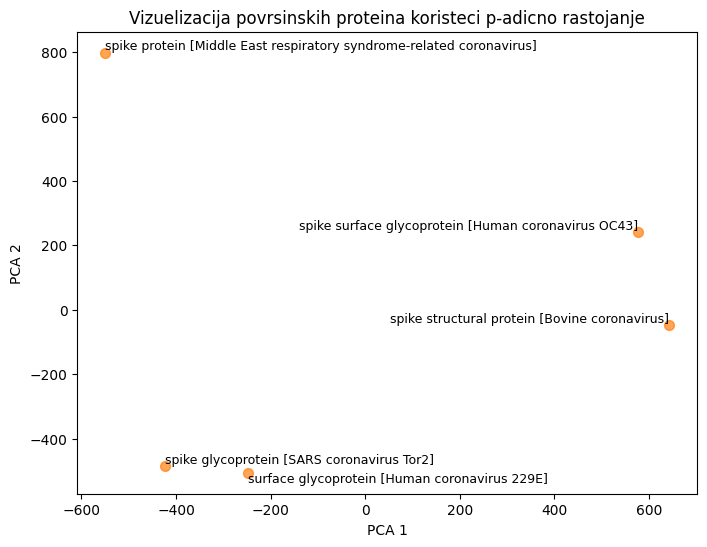

In [16]:
pca = PCA(n_components=2)
pca_matrica = pca.fit_transform(p_adicna_rastojanja1)

vizualizacija_povrsinskih_proteina(pca_matrica, povrsinski_proteini_nazivi, '#ff7f0e')

## Hamingovo rastojanje

In [17]:
def hamingovo_rastojanje(a, b): # a i b su sekvence kodona ili aminokiselina
    a = np.array(list(a))
    b = np.array(list(b))

    haming = 0
    for x, y in zip(a, b):
        if str(x) != str(y):
            haming += 1
    
    return haming

### elementi su kodoni

In [18]:
# 1. pristup
h_rastojanja1 = np.zeros((len(povrsinski_proteini), len(povrsinski_proteini)))
for i in range(len(povrsinski_proteini) - 1):
    for j in range(i+1, len(povrsinski_proteini)):
        virus1, rnk1 = list(povrsinski_proteini.items())[i]
        virus2, rnk2 = list(povrsinski_proteini.items())[j]

        rnk1, rnk2 = izjednacavanje_sekvenci_kodonima(rnk1, rnk2)
        rnk1_kodoni, rnk2_kodoni = rnk_u_kodone(rnk1), rnk_u_kodone(rnk2)

        haming = hamingovo_rastojanje(rnk1_kodoni, rnk2_kodoni)
        h_rastojanja1[i][j] = h_rastojanja1[j][i] = haming
        

# 2. pristup
h_rastojanja2 = np.zeros((len(povrsinski_proteini), len(povrsinski_proteini)))
for i in range(len(povrsinski_proteini) - 1):
    for j in range(i+1, len(povrsinski_proteini)):
        virus1, rnk1 = list(povrsinski_proteini.items())[i]
        virus2, rnk2 = list(povrsinski_proteini.items())[j]

        rnk1, rnk2 = izjednacavanje_sekvenci_nukleotidima(rnk1, rnk2)
        rnk1_kodoni, rnk2_kodoni = rnk_u_kodone(rnk1), rnk_u_kodone(rnk2)

        haming = hamingovo_rastojanje(rnk1_kodoni, rnk2_kodoni)
        h_rastojanja2[i][j] = h_rastojanja2[j][i] = haming

In [19]:
hamingova_rastojanja1 = pd.DataFrame(h_rastojanja1, index = povrsinski_proteini_nazivi, columns = povrsinski_proteini_nazivi)
hamingova_rastojanja2 = pd.DataFrame(h_rastojanja2, index = povrsinski_proteini_nazivi, columns = povrsinski_proteini_nazivi)

In [20]:
html_code = """
<div style="text-align: center; font-weight: bold; color: green; font-size: 16px">
    Hamingova rastojanja kada krace sekvence dopunjujemo najfrekventnijim kodonom
</div>
"""
display(HTML(html_code))

hamingova_rastojanja1

,spike structural protein [Bovine coronavirus],surface glycoprotein [Human coronavirus 229E],spike surface glycoprotein [Human coronavirus OC43],spike protein [Middle East respiratory syndrome-related coronavirus],spike glycoprotein [SARS coronavirus Tor2]
spike structural protein [Bovine coronavirus],0.0,1317.0,1213.0,1334.0,1319.0
surface glycoprotein [Human coronavirus 229E],1317.0,0.0,1300.0,1322.0,1218.0
spike surface glycoprotein [Human coronavirus OC43],1213.0,1300.0,0.0,1316.0,1326.0
spike protein [Middle East respiratory syndrome-related coronavirus],1334.0,1322.0,1316.0,0.0,1321.0
spike glycoprotein [SARS coronavirus Tor2],1319.0,1218.0,1326.0,1321.0,0.0


In [21]:
html_code = """
<div style="text-align: center; font-weight: bold; color: green; font-size: 16px">
    Hamingova rastojanja kada krace sekvence dopunjujemo najfrekventnijim nukleotidom
</div>
"""
display(HTML(html_code))

hamingova_rastojanja2

,spike structural protein [Bovine coronavirus],surface glycoprotein [Human coronavirus 229E],spike surface glycoprotein [Human coronavirus OC43],spike protein [Middle East respiratory syndrome-related coronavirus],spike glycoprotein [SARS coronavirus Tor2]
spike structural protein [Bovine coronavirus],0.0,1320.0,1213.0,1334.0,1319.0
surface glycoprotein [Human coronavirus 229E],1320.0,0.0,1304.0,1328.0,1220.0
spike surface glycoprotein [Human coronavirus OC43],1213.0,1304.0,0.0,1316.0,1326.0
spike protein [Middle East respiratory syndrome-related coronavirus],1334.0,1328.0,1316.0,0.0,1321.0
spike glycoprotein [SARS coronavirus Tor2],1319.0,1220.0,1326.0,1321.0,0.0


### elementi su aminokiseline

In [22]:
# 1. pristup
h_rastojanja3 = np.zeros((len(povrsinski_proteini), len(povrsinski_proteini)))
for i in range(len(povrsinski_proteini) - 1):
    for j in range(i+1, len(povrsinski_proteini)):
        virus1, rnk1 = list(povrsinski_proteini.items())[i]
        virus2, rnk2 = list(povrsinski_proteini.items())[j]
        
        rnk1, rnk2 = izjednacavanje_sekvenci_kodonima(rnk1, rnk2)
        
        rnk1_sekv = Seq(rnk1).translate()
        rnk2_sekv = Seq(rnk2).translate()

        haming = hamingovo_rastojanje(rnk1_sekv, rnk2_sekv)
        h_rastojanja3[i][j] = h_rastojanja3[j][i] = haming
        

# 2. pristup
h_rastojanja4 = np.zeros((len(povrsinski_proteini), len(povrsinski_proteini)))
for i in range(len(povrsinski_proteini) - 1):
    for j in range(i+1, len(povrsinski_proteini)):
        virus1, rnk1 = list(povrsinski_proteini.items())[i]
        virus2, rnk2 = list(povrsinski_proteini.items())[j]
        
        rnk1, rnk2 = izjednacavanje_sekvenci_nukleotidima(rnk1, rnk2)

        rnk1 = Seq(rnk1).translate()
        rnk2 = Seq(rnk2).translate()
        
        
        haming = hamingovo_rastojanje(rnk1, rnk2)
        h_rastojanja4[i][j] = h_rastojanja4[j][i] = haming

In [23]:
hamingova_rastojanja3 = pd.DataFrame(h_rastojanja3, index = povrsinski_proteini_nazivi, columns = povrsinski_proteini_nazivi)
hamingova_rastojanja4 = pd.DataFrame(h_rastojanja4, index = povrsinski_proteini_nazivi, columns = povrsinski_proteini_nazivi)

In [24]:
html_code = """
<div style="text-align: center; font-weight: bold; color: green; font-size: 16px">
    Hamingova rastojanja kada krace sekvence dopunjujemo najfrekventnijim kodonom
</div>
"""
display(HTML(html_code))

hamingova_rastojanja3

,spike structural protein [Bovine coronavirus],surface glycoprotein [Human coronavirus 229E],spike surface glycoprotein [Human coronavirus OC43],spike protein [Middle East respiratory syndrome-related coronavirus],spike glycoprotein [SARS coronavirus Tor2]
spike structural protein [Bovine coronavirus],0.0,1269.0,1163.0,1283.0,1267.0
surface glycoprotein [Human coronavirus 229E],1269.0,0.0,1254.0,1282.0,1162.0
spike surface glycoprotein [Human coronavirus OC43],1163.0,1254.0,0.0,1260.0,1294.0
spike protein [Middle East respiratory syndrome-related coronavirus],1283.0,1282.0,1260.0,0.0,1269.0
spike glycoprotein [SARS coronavirus Tor2],1267.0,1162.0,1294.0,1269.0,0.0


In [25]:
html_code = """
<div style="text-align: center; font-weight: bold; color: green; font-size: 16px">
    Hamingova rastojanja kada krace sekvence dopunjujemo najfrekventnijim nukleotidom
</div>
"""
display(HTML(html_code))

hamingova_rastojanja4

,spike structural protein [Bovine coronavirus],surface glycoprotein [Human coronavirus 229E],spike surface glycoprotein [Human coronavirus OC43],spike protein [Middle East respiratory syndrome-related coronavirus],spike glycoprotein [SARS coronavirus Tor2]
spike structural protein [Bovine coronavirus],0.0,1275.0,1163.0,1284.0,1267.0
surface glycoprotein [Human coronavirus 229E],1275.0,0.0,1263.0,1284.0,1165.0
spike surface glycoprotein [Human coronavirus OC43],1163.0,1263.0,0.0,1260.0,1294.0
spike protein [Middle East respiratory syndrome-related coronavirus],1284.0,1284.0,1260.0,0.0,1269.0
spike glycoprotein [SARS coronavirus Tor2],1267.0,1165.0,1294.0,1269.0,0.0
